# Dataset Introduction

In this project we want to predict the wine quality score. The score is a number between 0 and 10. The quality of a wine is determined by 11 input variables:

* fixed acidity
* volatile acidity
* citric acid
* residual sugar
* chlorides
* free sulfur dioxide
* total sulfur dioxide
* density
* pH
* sulfates
* alcohol

# Exploratory Data Analysis

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb

# Unbalance class libraries
from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [264]:
# Load dataset from UCI
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep =';')


In [265]:
# Number of rows and columns
print("(rows, columns) : " + str(df.shape))

# First five rows of the dataset
df.head(n=5)

(rows, columns) : (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


This dataset has 1599 observations, 11 features and 1 target variable. 

In [266]:
# Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


We can see that our dataset has only floats (features) and integer values (target variable). Non of the variable column has null or missing values.

In [267]:
# summary statistics for features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


There is a large difference between 75th percentile and max values of features "residual sugar", "free sulfur dioxide", "total sulfur dioxide" suggesting we have outliers in our dataset.

In [268]:
# summary statistics target variable
print(df.quality.value_counts().sort_index())

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64


"quality" score ranges from 1 to 10 but we can see that wines scores in this dataset are between 3 to 8. Also that this dataset is not balance as we have most values concentrated in the categories 5, 6 and 7.

In [269]:
df.duplicated().sum()

240

We assume that the duplicated rows are from several wine tasters rating the same wine similarly. So we keep all the observations as this can add more information.

## Outliers

<AxesSubplot:xlabel='residual sugar'>

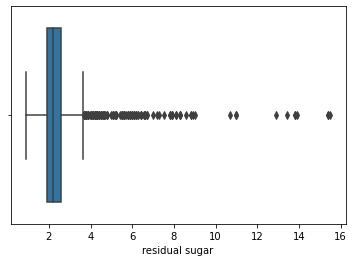

In [270]:
sns.boxplot(x='residual sugar', data=df, orient = 'h')

In [271]:
# If we remove outliers with z-score we lost 9% of the data and observation for the quality score '3'.
# We use flooring and capping to calculate 1% and 99% to replace outliers.

# Print data maximums 
print(df.max())

for col in df.columns.difference(['quality']):
    percentiles = df[col].quantile([0.01, 0.99]).values
    df[col] = df[col].clip(percentiles[0], percentiles[1])

# Print data maximums after capping and flooring
print(df.max())
print(df.shape)


fixed acidity            15.90000
volatile acidity          1.58000
citric acid               1.00000
residual sugar           15.50000
chlorides                 0.61100
free sulfur dioxide      72.00000
total sulfur dioxide    289.00000
density                   1.00369
pH                        4.01000
sulphates                 2.00000
alcohol                  14.90000
quality                   8.00000
dtype: float64
fixed acidity            13.300000
volatile acidity          1.020000
citric acid               0.700200
residual sugar            8.306000
chlorides                 0.360160
free sulfur dioxide      50.020000
total sulfur dioxide    145.000000
density                   1.001506
pH                        3.700200
sulphates                 1.260400
alcohol                  13.400000
quality                   8.000000
dtype: float64
(1599, 12)


# Feature Selection

## Correlation

<AxesSubplot:>

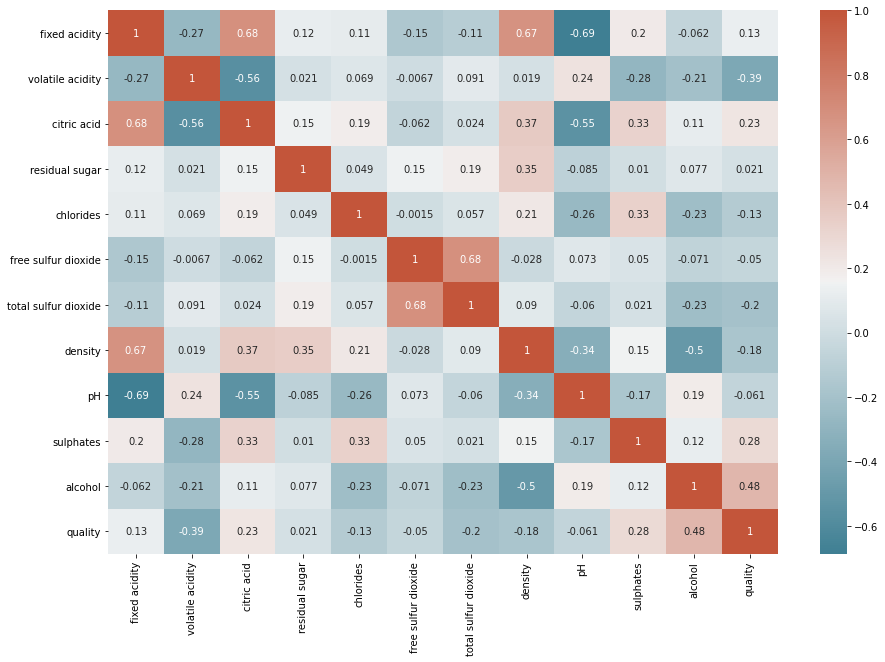

In [272]:
corr = df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Although none of the columns show high correlation with the target colummn, we can say that Alcohol, Sulphates, Volatile acidity have the highest correlations.

In [273]:
X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (1279, 11) (1279,)
Test set: (320, 11) (320,)


# Models

## Unchanged dataset

### Logistic Regression

In [274]:
seed = 2

In [275]:
# Train and fit model
logreg = LogisticRegression(multi_class='multinomial', solver ='newton-cg', random_state = seed)
logreg.fit(X_train, y_train)

# Predict out-of-sample test set
y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score (logreg, X, y, scoring = 'roc_auc_ovr', cv=10)
print('cross validation score with roc_auc',accuracy.mean())


# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           3      1.000     0.000     0.000         1
           4      1.000     0.000     0.000         9
           5      0.594     0.754     0.664       122
           6      0.613     0.592     0.602       147
           7      0.478     0.306     0.373        36
           8      1.000     0.000     0.000         5

    accuracy                          0.594       320
   macro avg      0.781     0.275     0.273       320
weighted avg      0.608     0.594     0.572       320

cross validation score with roc_auc 0.7879195562124399
roc_auc_score 0.8029223959816988


Scores 3, 4 and 8 have not been taken into consideration when training because their recall results are zero. This means, these classes were not predicted correctly. This is not a good model for our dataset.

### Random Forest

In [276]:
# Train and fit the Random Forest Classification model
rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train, y_train)

# Test out-of-sample test set
y_pred = rf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score (rf, X, y, scoring = 'roc_auc_ovr', cv=10)
print('cross validation score with roc_auc',accuracy.mean())

# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           3      1.000     0.000     0.000         1
           4      1.000     0.000     0.000         9
           5      0.638     0.779     0.701       122
           6      0.687     0.612     0.647       147
           7      0.538     0.583     0.560        36
           8      1.000     0.200     0.333         5

    accuracy                          0.647       320
   macro avg      0.811     0.362     0.374       320
weighted avg      0.666     0.647     0.633       320

cross validation score with roc_auc 0.7980835483791368
roc_auc_score 0.8678871098697728


In [277]:
# Train and fit the Random Forest Classification model
xgbc = xgb.XGBClassifier(random_state = seed, objective='multi:softmax', num_class = 6, eval_metric='mlogloss')
xgbc.fit(X_train, y_train)

# Test out-of-sample test set
y_pred = xgbc.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score (xgbc, X, y, scoring = 'roc_auc_ovr', cv=10)
print('cross validation score with roc_auc',accuracy.mean())

# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(y_test, xgbc.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           3      1.000     0.000     0.000         1
           4      0.000     0.000     0.000         9
           5      0.657     0.770     0.709       122
           6      0.708     0.660     0.683       147
           7      0.595     0.611     0.603        36
           8      1.000     0.200     0.333         5

    accuracy                          0.669       320
   macro avg      0.660     0.374     0.388       320
weighted avg      0.662     0.669     0.657       320

cross validation score with roc_auc 0.7684421350589004
roc_auc_score 0.8532827893784697


If we have a high class imbalance we choose the f1 score because a high f1 score considers both precision and recall.

## Handling imbalance dataset

We use SMOTE algorithm to oversample our unbalance dataset. SMOTE (Synthetic Minority Over-Sampling) algorithm creates synthetic minority class samples to increase the representation of minority classes.

In [278]:
# Oversample training set to create a new training set
oversample = SMOTE(random_state = seed)
X_train_up, y_train_up = oversample.fit_resample(X_train, y_train.ravel())

# summarize the new class distribution
print(sorted(Counter(y_train_up).items()))

[(3, 559), (4, 559), (5, 559), (6, 559), (7, 559), (8, 559)]


### Logistic Regression

In [279]:
#The model to the new train set
logreg = LogisticRegression(multi_class='multinomial', solver ='newton-cg', random_state = seed)
logreg.fit(X_train_up, y_train_up.ravel())

# Test out-of-sample test set
y_pred = logreg.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score (logreg, X, y, scoring = 'roc_auc_ovr', cv=10)
print('cross validation score with roc_auc',accuracy.mean())

# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           3      0.000     0.000     0.000         1
           4      0.077     0.333     0.125         9
           5      0.670     0.533     0.594       122
           6      0.632     0.327     0.430       147
           7      0.288     0.472     0.358        36
           8      0.083     0.400     0.138         5

    accuracy                          0.422       320
   macro avg      0.292     0.344     0.274       320
weighted avg      0.581     0.422     0.470       320

cross validation score with roc_auc 0.7879195562124399
roc_auc_score 0.7742400129152381


### Random Forest

In [280]:
#The model to the new train set
rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train_up, y_train_up.ravel())

# Test out-of-sample test set
y_pred = rf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score (rf, X, y, scoring = 'roc_auc_ovr', cv=10)
print('cross validation score with roc_auc',accuracy.mean())

# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

           3      0.000     0.000     0.000         1
           4      0.000     0.000     0.000         9
           5      0.711     0.705     0.708       122
           6      0.717     0.585     0.644       147
           7      0.431     0.611     0.506        36
           8      0.400     0.400     0.400         5

    accuracy                          0.613       320
   macro avg      0.376     0.384     0.376       320
weighted avg      0.655     0.613     0.629       320

cross validation score with roc_auc 0.7980835483791368
roc_auc_score 0.8636697017479209


### Random XGBoost

In [281]:
#The model to the new train set
xgbc = xgb.XGBClassifier(random_state = seed, objective='multi:softmax', num_class = 6, eval_metric='mlogloss')
xgbc.fit(X_train_up, y_train_up.ravel())

# Test out-of-sample test set
y_pred = xgbc.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3, zero_division = 1))

# Calculate cv score with ‘roc_auc_ovr’ scoring and 10 folds
accuracy = cross_val_score (xgbc, X, y, scoring = 'roc_auc_ovr', cv=10)
print('cross validation score with roc_auc',accuracy.mean())

# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(y_test, xgbc.predict_proba(X_test), multi_class='ovr'))


              precision    recall  f1-score   support

           3      0.000     0.000     0.000         1
           4      0.000     0.000     0.000         9
           5      0.661     0.689     0.675       122
           6      0.693     0.599     0.642       147
           7      0.469     0.639     0.541        36
           8      0.400     0.400     0.400         5

    accuracy                          0.616       320
   macro avg      0.371     0.388     0.376       320
weighted avg      0.630     0.616     0.619       320

cross validation score with roc_auc 0.7684421350589004
roc_auc_score 0.8314777219059954


# Conclusions


* Althought wine quality scores are theoretically from 1 to 10 the datasets has scores between 3 and 8.
* The dataset is extreme unbalance for scores 3, 4, 8 vs 5, 6, 7.
* Scores 3, 4 and 8 have not been taken into consideration when training with the unbalance dataset.
<br><br>
* We use SMOTE algorithm to oversample our unbalance dataset. Despite scores 4 and 8 are now taken into consideration the precision is not good.
* We can try another algorithm or techniques.
* Logistic Regression, Random Forest and XGBoost perfom similary in the oversample dataset.
<br><br>
* We can change our initial problem from multiclass to a binary classification problem. We can defined a bottle of wine as ‘good quality’ if it had a quality score of 7 or higher, and if it had a score of less than 7, ‘bad quality’.
* Also we can keep the multiclass classification problem using score bins from 0 to 5 (poor wine), 6 (good) and 7 or above (excellent)